<a href="https://colab.research.google.com/github/aminkarbassi/pytorch_course/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/Z_ikDlimN6A?t=32214

1. Make Data

In [ ]:
import sklearn

In [ ]:
from sklearn.datasets import make_circles

In [ ]:
from numpy.random.mtrand import random
# Make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples, 
                    noise= 0.03,
                    random_state= 42)


In [ ]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label": y})

In [ ]:
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [ ]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

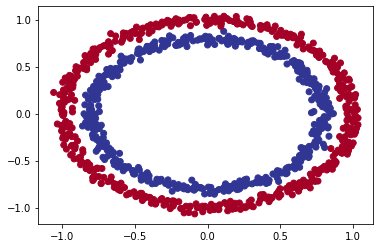

In [ ]:
# Visualize the circles
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

### Check input and output shapes

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
import torch
torch.__version__

'1.13.1+cu116'

In [ ]:
type(X)

numpy.ndarray

In [ ]:
# Turn data into tensor
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [ ]:
X.dtype

torch.float32

In [ ]:
# split data to train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size= 0.2,
                                                    random_state=42)


In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [ ]:
X_train.dtype

torch.float32

2. Building a model

In [ ]:
import torch
from torch import nn

# make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

https://youtu.be/Z_ikDlimN6A?t=34074

In [ ]:
from sklearn import datasets

In [ ]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # Construct 2 nn.Linear layers capable of handling the shape of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upsclaes to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feature 

  # 3. Define a forward() method that outliones the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output


In [ ]:
# 4. Instantiate an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
  

In [ ]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [ ]:
model_0.state_dict()

OrderedDict([('layer_1.weight', tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='cuda:0')),
             ('layer_1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0')),
             ('layer_2.bias', tensor([-0.2060], device='cuda:0'))])

http://payground.tensorflow.org/

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    # Construct 2 layer model with Sequential
    self.two_linear_layers = nn.Sequential(
        nn.Linear(in_features=2, out_features=5),
        nn.Linear(in_features=5, out_features=1)
    )

    # Define the forward() method
  def forward(self, x):
    return self.two_linear_layers(x)

In [ ]:
model_1 = CircleModelV1()

In [ ]:
model_1

CircleModelV1(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [ ]:
model_1.state_dict()

OrderedDict([('two_linear_layers.0.weight', tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('two_linear_layers.0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('two_linear_layers.1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('two_linear_layers.1.bias', tensor([-0.1213]))])

In [ ]:
# Make predictions
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")


Length of predictions: 200, Shape: torch.Size([200, 1])


until here: https://youtu.be/Z_ikDlimN6A?t=36696

In [ ]:
  # setup loss function and optimizer
  loss_fn = nn.BCEWithLogitsLoss()

  optimizer = torch.optim.SGD(params=model_0.parameters(),
                              lr=0.1)
  

In [ ]:
# Calculate assuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc


until here : https://youtu.be/Z_ikDlimN6A?t=37664

In [ ]:
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))

In [ ]:
# Check equality
#print(torch.eq(y_pred_labels.squeeze(),y_test.to(device)))

#y_pred_labels[:5]

In [ ]:
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Building training and evaluation loop
for epoch in range(epochs):
  #Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits, 
                 y_train)
  acc= accuracy_fn(y_true =y_train,y_pred=y_pred)

  # 3. Opimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Evaluation
  model_0.eval()
  with torch.inference_mode():
    # forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
  
  # Print out what is happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss : {loss:0.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%") 




Epoch: 0 | Loss : 0.69569, Acc: 50.00% | Test loss: 0.69721, Test acc: 50.00%
Epoch: 10 | Loss : 0.69403, Acc: 50.00% | Test loss: 0.69615, Test acc: 50.00%
Epoch: 20 | Loss : 0.69343, Acc: 46.00% | Test loss: 0.69585, Test acc: 48.50%
Epoch: 30 | Loss : 0.69321, Acc: 49.00% | Test loss: 0.69577, Test acc: 47.50%
Epoch: 40 | Loss : 0.69312, Acc: 49.50% | Test loss: 0.69573, Test acc: 46.50%
Epoch: 50 | Loss : 0.69308, Acc: 50.38% | Test loss: 0.69569, Test acc: 46.50%
Epoch: 60 | Loss : 0.69306, Acc: 50.50% | Test loss: 0.69564, Test acc: 46.50%
Epoch: 70 | Loss : 0.69305, Acc: 50.50% | Test loss: 0.69559, Test acc: 46.50%
Epoch: 80 | Loss : 0.69304, Acc: 50.75% | Test loss: 0.69553, Test acc: 46.50%
Epoch: 90 | Loss : 0.69303, Acc: 50.38% | Test loss: 0.69547, Test acc: 46.50%


In [ ]:
import requests
from pathlib import Path

# Download helper fuctions from Pytroch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exisits, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary 

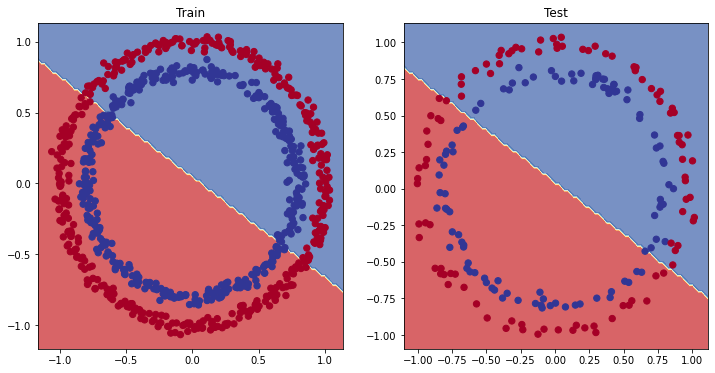

In [ ]:
# Plot decision boundary of the model
plt.figure (figsize=(12,6))
plt.subplot(1 ,2 ,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1 ,2 ,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

until here: https://youtu.be/Z_ikDlimN6A?t=44801

---



### Recreating non-linear data

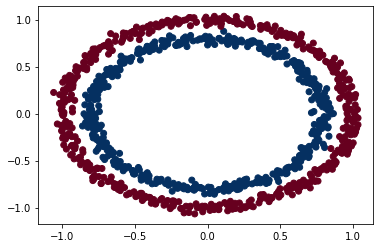

In [ ]:
# Make and plot Data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=n_samples, 
                    noise = 0.03,
                    random_state= 42)

plt.scatter(X[:,0], X[:,1], c=y, cmap = plt.cm.RdBu)

In [ ]:
# convert to tensor and split into train and test
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size= 0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]), tensor([1., 0., 0., 0., 1.]))

In [ ]:
X.dtype

torch.float32

In [ ]:
from torch.autograd import forward_ad
# Building model with non-linear actication function
from torch import nn

# make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()
  
  def forward(self, x):
    # Intersperse the ReLU activation function between layers
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)





CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


until here: https://youtu.be/Z_ikDlimN6A?t=44804

In [ ]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),lr=0.1)

### Tranining the model with non-linearity

In [ ]:
# Fit the model
torch.manual_seed(42)
epochs = 2000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  #1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

  #2. Calculate loss and accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true = y_train, y_pred=y_pred)

  #3. Optimizer zero grad
  optimizer.zero_grad()

  #4. Loss backward
  loss.backward()

  #5. Optimizer
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    #1. forward pass
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels

    #2. Calculate loss and accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true= y_test,
                           y_pred=test_pred)

  #Print out what is happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%") 






Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%
Epoch: 1000 | Loss: 0.56818, Accuracy: 87.75% | Test Loss: 0.57378, Test Accuracy: 86.50%
Epoch: 1100 | Loss: 0.

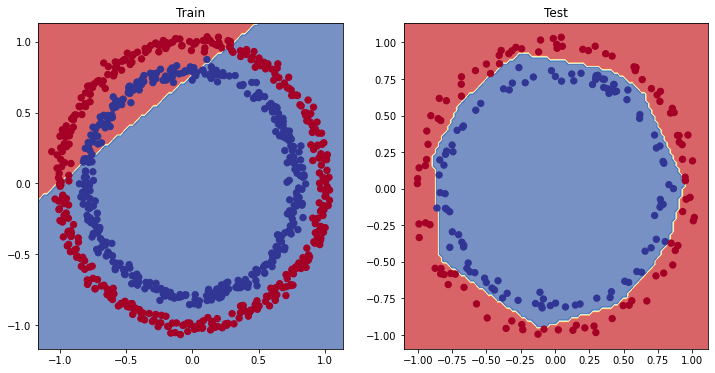

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) #model_1 = no non-linear
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) #model_3 = with non-linearity
